# Figure 6: Averaged RMSE per sample number for each canonical phenotype

## Manuscript Information
 
"Contrast Response Function Estimation with Nonparametric Bayesian Active Learning"  
_Journal of Vision_
https://www.medrxiv.org/content/10.1101/2023.05.11.23289869v2

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis

## Figure Description

Displays the mean and standard deviation root-mean-square error (RMSE) values for four canonical phenotypes with respect to number of samples, averaged across 10 repeated experiments. Four conditions were used to sample up to 100 points, namely random with uninformative priors (RUP), random with informative priors (RIP), active with uninformative priors (AUP) and active with informative priors (AIP). Performance of quickCSF on the same estimation tasks is also displayed.

## References

Kalloniatis, Michael, and Charles Luu. “Visual Acuity.” In _Webvision: The Organization of the Retina and Visual System_, edited by Helga Kolb, Eduardo Fernandez, and Ralph Nelson. Salt Lake City (UT): University of Utah Health Sciences Center, 1995. http://www.ncbi.nlm.nih.gov/books/NBK11509/.

Canare, D., Ni, R., & Lu, T. (2019). An open-source implementation of the Quick CSF method. Journal of Vision, 19(10), 86b. https://doi.org/10.1167/19.10.86b

In [1]:
# Import libraries

from utility.utils import *
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import gpytorch as gp
import torch as pt
import sys
import seaborn as sns
import json
import datetime
import os
from QuickCSF import simulate

Check versions of python, Gpytorch, and Pytorch dependencies

In [2]:
# Check versions of imported libraries

print("python version -->>", sys.version)
print("gpytorch version -->>", gp.__version__)
print("pytorch version -->>", pt.__version__)

python version -->> 3.10.9 (main, Mar  8 2023, 04:44:36) [Clang 14.0.6 ]
gpytorch version -->> 1.8.1
pytorch version -->> 1.13.1


This code was written for

- python version 3.10.9
- pytorch version 1.13.1
- gpytorch version 1.8.1

In [3]:
# Run-time flags
create_mlcsf_results = False    # run new results for mlcsf?
create_qcsf_results = False     # run new results for qcsf?
make_gif = True                 # if creating results, save gifs for each run?

verb_mode = False               # print output when creating results?
show_figure = True              # plot on screen?
save_figure = True              # save plots in indicated directory?

In [4]:
# MLCSF Constant declarations

# evaluation grid bounds in raw linear units
# namely, cycles per degree and contrast
raw_freq_min = 1            
raw_freq_max = 64
raw_contrast_min = 1e-3
raw_contrast_max = 1

# log resolutions of evaulation grid
x_resolution = 15
y_resolution = 30

# for data simulation
generative_random_seed = 1
psi_gamma = .04
psi_lambda = .04
psi_sigma = .08
sigmoid_type = 'logistic'

# ghost points (all labelled as 0s)
raw_freq_ghost_points = [1, 2, 4, 8, 16, 32, 64, 128]
raw_contrast_ghost_points = [5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1]

# prior specifications
prior_raw_freq_min = 0.5
prior_raw_freq_max = 64
prior_raw_contrast_min = 1e-3
prior_raw_contrast_max = 1

prior_model_names = ['textbook'] 
gaussian_lengthscale = None
scale_factor = 0.4

# ensure needed values are calculated during training
calculate_rmse = True
calculate_entropy = True
calculate_posterior = True
train_after_sampling = False        # train on all data points after sampling?

# number of datapoints and experiments
num_experiments_to_average = 10
num_halton_samples = 8
num_new_points = 92

# GP hyperparameters
num_initial_points_training_iters = 500
num_new_points_training_iters = 150
beta_for_regularization = 0.25
min_lengthscale = .15
lr = .125

# verbose settings
if verb_mode:
    print_training_iters = True        # prints every additional data point
    print_training_hyperparameters = True   # prints lengthscale after each learned GP
    progress_bar = False                # displays progress bar for each GP
else:
    print_training_iters = False        
    print_training_hyperparameters = False   
    progress_bar = False                
           
# number of data points where elapsed time is calculated
timepoints = [10, 20, 50, 100]

# directories + filenames
top_level_results_dir = 'data/'
mlcsf_results_dir = f'{top_level_results_dir}figure_06/'
mlcsf_gif_dir = f'analysis/gifs/figure_06/'

# to load existing results files, overwritten if create_mlcsf_results=True
mlcsf_filename = 'results_2023-09-22_17-37-24.json'

In [5]:
# qCSF Constant Declarations

# Note that other parameters are defined to match mlcsf above
qcsf_num_trials = 100

d = 1   # 1-guess_rate used by qCSF model
qcsf_psi_gammma = 0
qcsf_psi_lambda = 0

qcsf_dir = f'{top_level_results_dir}qcsf_experiment_1/'
qcsf_gif_dir = f'analysis/gifs/qcsf_experiment_1/'
qcsfGifPrefix = 'qcsf_'

# used when create_qcsf_results=False
qcsf_filename = 'results_2023-09-22_15-38-10.json' 

In [6]:
# Plotting parameters

# to create subplots
num_rows = 2
num_cols = 2

title_font_size = 12
label_font_size = 10
tick_font_size = 8
legend_font_size = 8
matplotlib.rcParams['font.family'] = 'Arial'

colors = sns.color_palette('colorblind')  # colorblind friendly palette

fig_width = 8   # in inches 
fig_height = 6  # in inches

dpi = 600              # graphics resolution

x_ticks = [0, 20, 40, 60, 80, 100]
y_ticks = [0, 0.2, 0.4, 0.6, 0.8]

x_axis_min = 0
x_axis_max = 100
y_axis_min = 0
y_axis_max = 0.8

x_label_x_pos = 0.51
x_label_y_pos = 0.04
y_label_x_pos = 0.06
y_label_y_pos = 0.5

axis_tick_params = {
    'axis':'both', 
    'which':'major', 
    'direction':'out',
    'length': 2
}

std_transparency = 0.2  # transparency for std deviation range
legend_location = 'upper right'

# enums
MLCSF, QCSF = 0, 1

aup_color = 'blue'
aip_color = 'green'
rup_color = 'red'
rip_color = 'orange'
qcsf_color = 'purple'

aup_label = 'AUP'
aip_label = 'AIP'
rup_label = 'RUP'
rip_label = 'RIP'
qcsf_label = 'qCSF'

x_label = 'Sample Count'
y_label = 'RMSE (log10 contrast)'

plot_dir = 'analysis/figure_06/'  # where to save figure
save_filename = 'Figure06_CanonicalEfficiency'

## Create MLCSF Results

In [7]:
# MLCSF setup

# list of phenotypes with titles

data_dir = 'data/raw_data/'
data_file_name = 'csf_curves_exp1.json'
data_file_path = f'{data_dir}{data_file_name}'

csf_curves_exp1 = load_json_from_file(data_file_path)

phenotypes = [
    ('Normal', csf_curves_exp1['normal']),
    ('Mild Amblyopia', csf_curves_exp1['mild_amblyopia']),
    ('Cataracts', csf_curves_exp1['cataracts']),
    ('Multiple Sclerosis', csf_curves_exp1['multiple_sclerosis'])
]

phenos_to_use = phenotypes[:]

# setup ghost points
assert len(raw_freq_ghost_points) == len(raw_contrast_ghost_points), "Make sure ghost point arrays have the same length"

freq_ghost_points = logFreq().forward(np.array(raw_freq_ghost_points))
contrast_ghost_points = logContrast().forward(np.array(raw_contrast_ghost_points))
ghost_X = np.vstack((freq_ghost_points, contrast_ghost_points)).T
ghost_y = np.array([0]*len(freq_ghost_points))

num_ghost_points = len(ghost_y)

# Transform raw bounds
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # flipped max and min when inverting
y_max = logContrast().forward(raw_contrast_min)

# Make grid
grid, xx, yy, xs, ys = create_evaluation_grid_resolution(x_min, x_max, y_min, y_max, x_resolution, y_resolution)

# transform raw prior bounds for scaling
prior_freq_min = logFreq().forward(prior_raw_freq_min)
prior_freq_max = logFreq().forward(prior_raw_freq_max)
prior_contrast_min = logContrast().forward(prior_raw_contrast_max) # 1/x swaps min and max
prior_contrast_max = logContrast().forward(prior_raw_contrast_min)

In [8]:
# Create MLCSF results if desired

if create_mlcsf_results:
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    
    results_object = {
        'description': 'description',
        'datetime': timestamp,
        'generative_random_seed': generative_random_seed,
    }
    print('datetime =', results_object['datetime'])

    for title, curve in phenos_to_use:

        ###################
        # CONSTRUCT CURVE #
        ###################
        set_random_seed(generative_random_seed)

        curve = np.array(curve)
        # prepare freqs - turn log10 to log2, and start from 0
        curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
        left, right, bottom, top = get_data_bounds(curve)

        cs = create_cubic_spline(curve)

        ################
        # TRAIN MODELS #
        ################

        # define how to transform the data
        def f(d):
            return scale_data_within_range(d, (0, 1), prior_freq_min, prior_freq_max, prior_contrast_min, prior_contrast_max)

        # create initial data points
        halton_X, halton_y = halton_samples_from_data(xx, yy, cs, psi_gamma, psi_lambda, num_halton_samples, sigmoid_type=sigmoid_type, psi_sigma = psi_sigma)
            
        initial_Xs = np.vstack((ghost_X, halton_X))
        initial_ys = np.hstack((ghost_y, halton_y))        
        
        # setup priors
        param_dicts = []

        for prior_model_name in prior_model_names: 
            param_dict = {
                'state_dict_path': f'data/priors/prior_mean_model_state_{prior_model_name}.pth',
                'Xt_path': f'data/priors/prior_mean_model_Xt_{prior_model_name}.pth',
                'scale_factor': scale_factor,
                'gaussian_lengthscale': gaussian_lengthscale,
                'min_lengthscale': min_lengthscale,
                'psi_gamma': psi_gamma,
                'psi_lambda': psi_lambda,
            }
            param_dicts.append(param_dict)

        # define base parameters for all conditions
        base_params = {
            "cs": cs,
            "grid": grid,
            "xx": xx,
            "yy": yy,
            "psi_sigma": psi_sigma,
            "sigmoid_type": sigmoid_type,
            "psi_gamma": psi_gamma,
            "psi_lambda": psi_lambda,
            "lr": lr,
            "num_initial_training_iters": num_initial_points_training_iters,
            "num_new_points_training_iters": num_new_points_training_iters,
            "num_new_points": num_new_points,
            "beta_for_regularization": beta_for_regularization,
            "train_on_all_points_after_sampling": train_after_sampling,
            "phi": f,
            "print_training_hyperparameters": print_training_hyperparameters,
            "print_training_iters": print_training_iters,
            "progress_bar": progress_bar,
            "min_lengthscale": min_lengthscale,
            "calculate_rmse": calculate_rmse,
            "calculate_entropy": calculate_entropy,
            "calculate_posterior": calculate_posterior,
            "initial_Xs": initial_Xs,
            "initial_ys": initial_ys,
            "num_ghost_points": num_ghost_points,
            "timepoints": timepoints
        }
        
        # do an experiment for each condition, will average over these
        for experiment in range(num_experiments_to_average):

            print(f'{title} - Experiment: {experiment + 1}')

            random_seed = experiment+1

            active_rmse = []
            random_rmse = []
            aprior_rmse = []
            rprior_rmse = []

            ##########
            # ACTIVE #
            ##########

            set_random_seed(random_seed)

            _, _, X_active, y_active, active_rmse_list, _, active_posterior_list, active_times = sample_and_train_gp(
                sampling_strategy='active',
                mean_module_name='constant_mean',
                **base_params
            )

            active_results_dict = {
                'xx': xx,
                'yy': yy,
                'X': X_active,
                'y': y_active,
                'left': left,
                'right': right,
                'top': top,
                'bottom': bottom,
                'cs': cs,
                'psi_sigma': psi_sigma,
                'sigmoid_type': sigmoid_type,
                'psi_gamma': psi_gamma,
                'psi_lambda': psi_lambda,
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'xs': xs,
                'ys': ys,
                'grid': grid,
                'f': f,
                'posterior_list': active_posterior_list,
            }

            ntitle = title.replace(' ', '_')

            gif_path = f'{mlcsf_gif_dir}{results_object["datetime"]}/{ntitle}/active/{experiment}/'

            if make_gif:
                create_and_save_plots(active_results_dict, gif_path, ntitle, start_index=num_ghost_points)
                create_gif(gif_path)
                
            ##########
            # RANDOM #
            ##########

            set_random_seed(random_seed)

            _, _, X_random, y_random, random_rmse_list, random_posterior_list, random_times = sample_and_train_gp(
                sampling_strategy='random',
                mean_module_name='constant_mean',
                **base_params
            )

            random_results_dict = {
                'xx': xx,
                'yy': yy,
                'X': X_random,
                'y': y_random,
                'left': left,
                'right': right,
                'top': top,
                'bottom': bottom,
                'cs': cs,
                'psi_sigma': psi_sigma,
                'sigmoid_type': sigmoid_type,
                'psi_gamma': psi_gamma,
                'psi_lambda': psi_lambda,
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'xs': xs,
                'ys': ys,
                'grid': grid,
                'f': f,
                'posterior_list': random_posterior_list,
            }

            ntitle = title.replace(' ', '_')
            gif_path = f'{mlcsf_gif_dir}{results_object["datetime"]}/{ntitle}/random/{experiment}/'

            if make_gif:
                create_and_save_plots(random_results_dict, gif_path, ntitle, start_index=num_ghost_points)
                create_gif(gif_path)

            ##########
            # APRIOR #
            ##########

            set_random_seed(random_seed)

            _, _, X_aprior, y_aprior, aprior_rmse_list, _, aprior_posterior_list, aprior_times = sample_and_train_gp(
                sampling_strategy='active',
                mean_module_name='prior_gp_mean',
                mean_module_params=param_dicts,
                **base_params
            )

            aprior_results_dict = {
                'xx': xx,
                'yy': yy,
                'X': X_aprior,
                'y': y_aprior,
                'left': left,
                'right': right,
                'top': top,
                'bottom': bottom,
                'cs': cs,
                'psi_sigma': psi_sigma,
                'sigmoid_type': sigmoid_type,
                'psi_gamma': psi_gamma,
                'psi_lambda': psi_lambda,
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'xs': xs,
                'ys': ys,
                'grid': grid,
                'f': f,
                'posterior_list': aprior_posterior_list,
            }

            ntitle = title.replace(' ', '_')
            gif_path = f'{mlcsf_gif_dir}{results_object["datetime"]}/{ntitle}/aprior/{experiment}/'

            if make_gif:
                create_and_save_plots(aprior_results_dict, gif_path, ntitle, start_index=num_ghost_points)
                create_gif(gif_path)

            ##########
            # RPRIOR #
            ##########

            set_random_seed(random_seed)

            _, _, X_rprior, y_rprior, rprior_rmse_list, rprior_posterior_list, rprior_times = sample_and_train_gp(
                sampling_strategy='random',
                mean_module_name='prior_gp_mean',
                mean_module_params=param_dicts,
                **base_params
            )

            rprior_results_dict = {
                'xx': xx,
                'yy': yy,
                'X': X_rprior,
                'y': y_rprior,
                'left': left,
                'right': right,
                'top': top,
                'bottom': bottom,
                'cs': cs,
                'psi_sigma': psi_sigma,
                'sigmoid_type': sigmoid_type,
                'psi_gamma': psi_gamma,
                'psi_lambda': psi_lambda,
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'xs': xs,
                'ys': ys,
                'grid': grid,
                'f': f,
                'posterior_list': rprior_posterior_list,
            }

            ntitle = title.replace(' ', '_')
            gif_path = f'{mlcsf_gif_dir}{results_object["datetime"]}/{ntitle}/rprior/{experiment}/'

            if make_gif:
                create_and_save_plots(rprior_results_dict, gif_path, ntitle, start_index=num_ghost_points)
                create_gif(gif_path)

            ##########
            # SAVING #
            ##########

            for i in range(num_halton_samples + num_new_points):
                active_rmse.append((i, active_rmse_list[i]))
                random_rmse.append((i, random_rmse_list[i]))
                aprior_rmse.append((i, aprior_rmse_list[i]))
                rprior_rmse.append((i, rprior_rmse_list[i]))

            exp_results = {
                'random_seed': random_seed,
                'active_rmse': active_rmse,
                'random_rmse': random_rmse,
                'aprior_rmse': aprior_rmse,
                'rprior_rmse': rprior_rmse,
                'active_times': active_times,
                'random_times': random_times,
                'aprior_times': aprior_times,
                'rprior_times': rprior_times,
            }

            if title not in results_object:
                results_object[title] = [exp_results]
            else:
                results_object[title].append(exp_results)

            # we save after each experiment, in case something crashes, we don't lose the data
            mlcsf_filename = f'results_{results_object["datetime"]}.json'
            ensure_directory_exists(mlcsf_results_dir)
            with open(mlcsf_results_dir + mlcsf_filename, 'w') as file:
                json.dump(results_object, file, indent=2)
else:
    print("No MLCSF results run...")

No MLCSF results run...


## Create qCSF Results

In [9]:
if create_qcsf_results:
    # constants for qcsf matched to mlcsf above
    simulationParams = {
        'trials': qcsf_num_trials,
        'stimuli': {
            'minContrast': raw_contrast_min,
            'maxContrast': raw_contrast_max,
            'contrastResolution': xs,
            'minFrequency': raw_freq_min,
            'maxFrequency': raw_freq_max,
            'frequencyResolution': ys,
        },
        'parameters': None,
        'd': d,             
        'psiGamma': qcsf_psi_gammma,
        'psiLambda': qcsf_psi_lambda,
        'psiSigma': psi_sigma,
        "sigmoidType": sigmoid_type,
        'timepoints': timepoints,
        'showPlots': False  # prevents plt from plotting every run 
    }

    # create new dir using datetime
    currDate = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    gifPath = f"{qcsf_gif_dir}{qcsfGifPrefix}{currDate}/"
    if not os.path.exists(qcsf_dir): os.mkdir(qcsf_dir)

    print("Timestamp:", currDate)

    # organize necessary parameters
    resultsObject = {
        'datetime': currDate,
        'numExperiments': num_experiments_to_average,
        **simulationParams
    }

    # Run qCSF 
    for title, curve in phenos_to_use:
        randomSeed = 1
        
        print(title)

        for experiment in range(num_experiments_to_average):
            print(f"Experiment {experiment}")

            curve = np.array(curve)        
            imagePath = f"{gifPath}{title}/{experiment}/" if make_gif else None

            rmses, times, params = simulate.runSimulation(
                trueThresholdCurve=curve,
                imagePath=imagePath,
                randomSeed=randomSeed,
                **simulationParams)

            expResults = {
                "random_seed": randomSeed,
                "rmses": rmses,
                "times": times,
                "params": params
            }

            if title not in resultsObject:
                resultsObject[title] = [expResults]
            else:
                resultsObject[title].append(expResults)

            if make_gif: create_gif(imagePath)

            qcsf_filename = f'results_{currDate}.json'
            ensure_directory_exists(qcsf_dir)
            with open(qcsf_dir + qcsf_filename, 'w') as file:
                json.dump(resultsObject, file, indent=2)

            randomSeed += 1
else:
    print("No qCSF results run...")

No qCSF results run...


## Plotting

In [10]:
# load results objects

with open(mlcsf_results_dir + mlcsf_filename, 'r') as file:
    mlcsf_results_object = json.load(file)

with open(qcsf_dir + qcsf_filename, 'r') as file:
    qcsf_results_object = json.load(file)

Figure06_datetime = mlcsf_results_object['datetime']
random_seed = mlcsf_results_object['generative_random_seed']


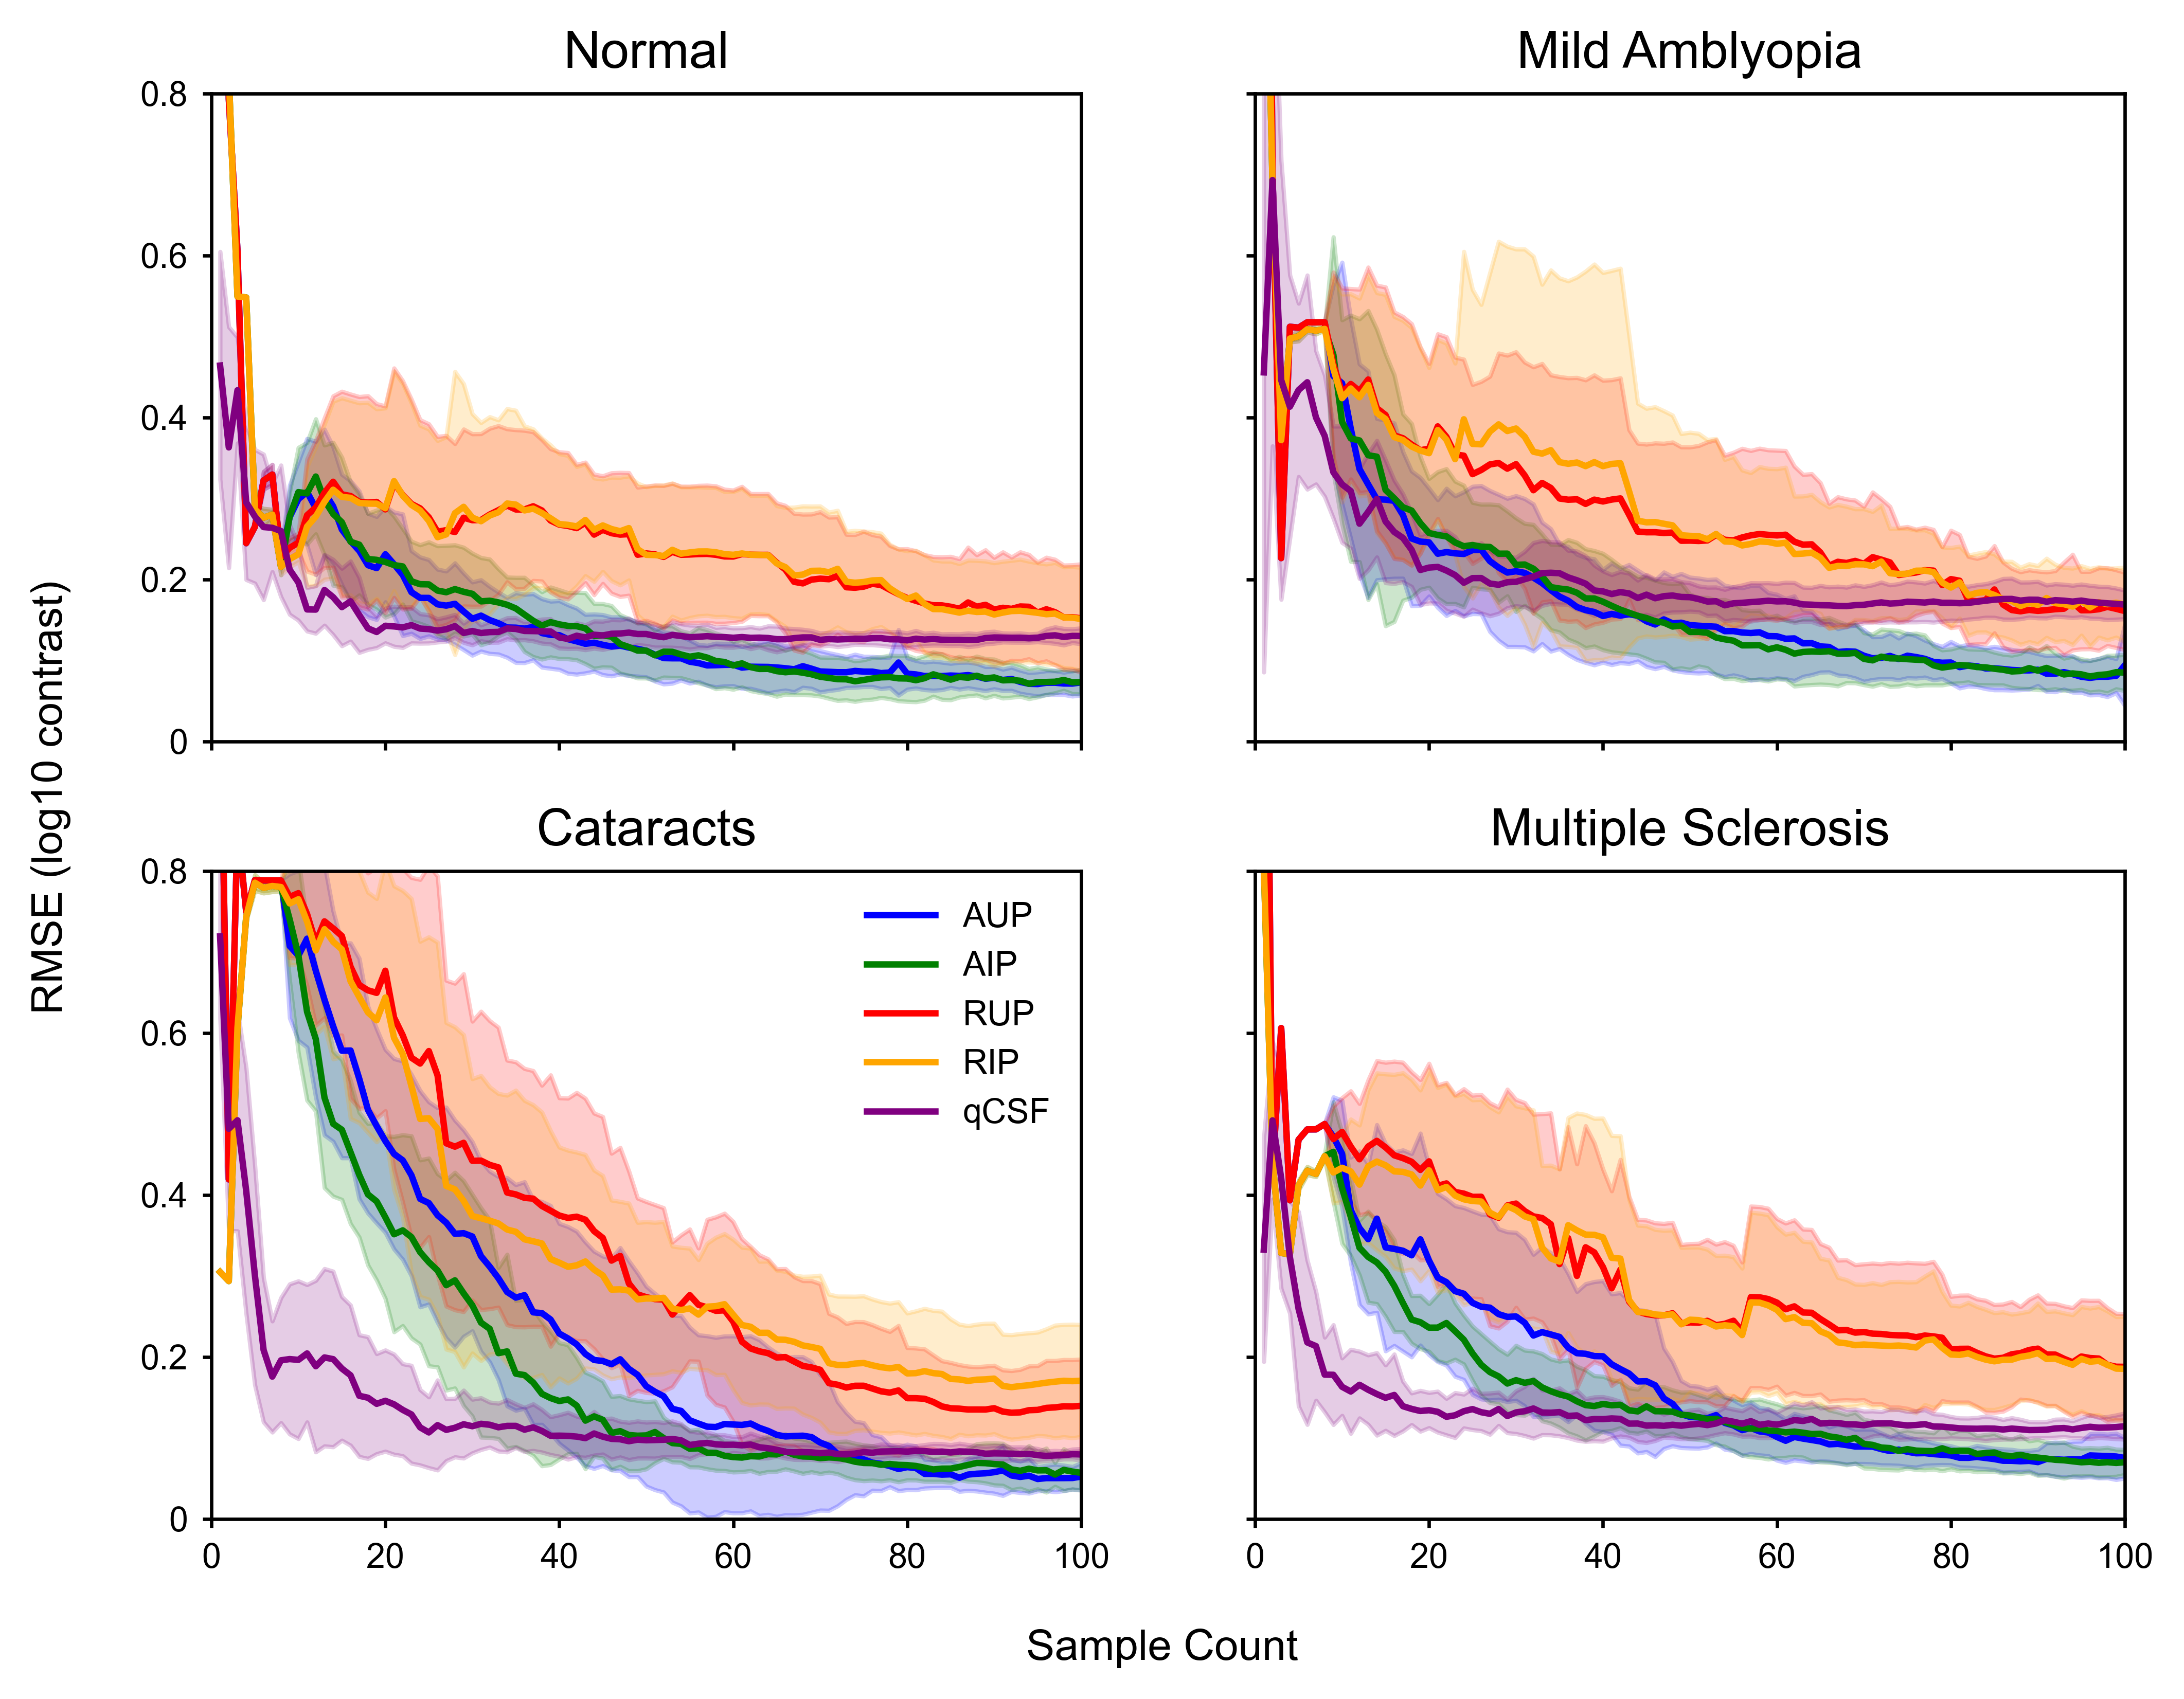

In [ ]:
# create RMSE plots

# plot only shows if plt.show() is called
plt.ioff()

# dictionary of settings for each condition, namely...
# key: label, color, model_type
conditions = {
    'active_rmse': (aup_label, aup_color, MLCSF),
    'aprior_rmse': (aip_label, aip_color, MLCSF),
    'random_rmse': (rup_label, rup_color, MLCSF),
    'rprior_rmse': (rip_label, rip_color, MLCSF),
    'rmses': (qcsf_label, qcsf_color, QCSF)
}

# plot each phenotype

fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), dpi=dpi)

for subplot_idx, (title, _) in enumerate(phenotypes):
    # get associated axis
    ax = axs[subplot_idx // num_rows, subplot_idx % num_rows]

    if title not in mlcsf_results_object:
        print(title, "field does not exist in the MLCSF results file")
        continue
    if title not in qcsf_results_object:
        print(title, "field does not exist in the qCSF results file")
        continue

    ############
    # PLOTTING #
    ############
    
    for condition, (label, color, model_type) in conditions.items():

        # load correct results according to model type
        if model_type == MLCSF:
            results_object = mlcsf_results_object
        else:
            results_object = qcsf_results_object

        # calculate RMSE 
        pheno_results = results_object[title]

        num_experiments = len(pheno_results)
        num_datapoints = len(pheno_results[0][condition])

        all_rmses = np.zeros((num_experiments, num_datapoints))

        for i, experiment in enumerate(pheno_results):
            if model_type == MLCSF:
                _, all_rmses[i,:] = zip(*experiment[condition]) # stored as (iteration_number, rmse)
            else:
                all_rmses[i,:] = experiment[condition]

        mean = np.mean(all_rmses, axis=0) 
        std = np.std(all_rmses, axis=0)
        
        # plot the mean
        sample_count = np.arange(1, num_datapoints+1) # 1-indexed
        ax.plot(sample_count, mean, label=label, color=color)

        # calculate the +/- std values
        upper = mean + std
        lower = mean - std

        # plot the shaded regions
        ax.fill_between(sample_count, upper, lower, alpha=std_transparency, color=color)

    # legend
    if title == 'Cataracts': ax.legend(loc=legend_location, fontsize=legend_font_size, frameon=False)
    
    ax.tick_params(**axis_tick_params, labelsize=tick_font_size)
    
    ax.set_xlim(x_axis_min, x_axis_max)
    ax.set_ylim(y_axis_min, y_axis_max)
        
    ax.set_title(title, fontsize=title_font_size)
    
plt.setp(axs, xticks=x_ticks, yticks=y_ticks)

for ax in axs.flat:
    # tick settings
    ax.label_outer() # only ticks on edges
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.tick_params(**axis_tick_params, labelsize=tick_font_size)

# x and y labels
fig.text(x_label_x_pos, x_label_y_pos, x_label, ha='center', va='center', fontsize=label_font_size)
fig.text(y_label_x_pos, y_label_y_pos, y_label, ha='center', va='center', rotation='vertical', fontsize=label_font_size)

# show the plot
if save_figure:
    ensure_directory_exists(plot_dir)
    plt.savefig(f'{plot_dir}{save_filename}.png', bbox_inches='tight', dpi=dpi)
    plt.savefig(f'{plot_dir}{save_filename}.pdf', bbox_inches='tight', dpi=dpi)
if show_figure:
    plt.show()
    